<h3>1 ▸ Imports & Data Load</h3>

In [15]:
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import matplotlib.pyplot as plt

# Load source Parquet files
DATA_DIR = "datasets"
files = {
    "collected": "collected_chat_datasets_2202.parquet",
    "lmsys"    : "lmsys-chat-691_categorized.parquet",
    "wildchat" : "wildchat-chat-843_categorized.parquet",
}

raw = {k: pd.read_parquet(f"{DATA_DIR}/{v}") for k, v in files.items()}

for name, df in raw.items():
    print(f"{name:10} → rows: {len(df):4} | cols: {df.shape[1]}")

collected  → rows: 2202 | cols: 3
lmsys      → rows:  691 | cols: 8
wildchat   → rows:  843 | cols: 15


<h3>2 ▸ Extract User Prompt → `query`</h3>

In [16]:
def extract_prompt(df, source):
    if source in {"lmsys", "wildchat"}:
        return df['conversation'].str[0].str['content']
    if source == "collected":
        return df['metadata'].apply(
            lambda m: m["conversation"][0]["content"]
            if isinstance(m, dict)
            and isinstance(m.get("conversation"), (list, np.ndarray))
            and len(m["conversation"]) > 0
            else None
        )
    raise ValueError("unknown source")

for name, df in raw.items():
    raw[name]["query"] = extract_prompt(df, name)

<h3>3 ▸ Check Superset Property</h3>

In [17]:
# Create sets of unique prompts
query_sets = {k: set(df["query"].dropna()) for k, df in raw.items()}

print("lmsys  ⊆ collected:", query_sets["lmsys"].issubset(query_sets["collected"]))
print("wildchat ⊆ collected:", query_sets["wildchat"].issubset(query_sets["collected"]))

lmsys  ⊆ collected: True
wildchat ⊆ collected: True


<h3>4 ▸ Drop Empty Rows</h3>

In [32]:
collected_non_empty = raw["collected"].dropna(subset=["query", "metadata"])
print("original rows:", len(raw["collected"]))
print("non-empty rows:", len(collected_non_empty))

original rows: 2202
non-empty rows: 1534


<h3>5 ▸ NSFW Filter (Stats‑Based)</h3>

In [33]:
import numpy as np

# ✅ Expanded NSFW flag function
def nsfw_flag(m: dict, thresh: float = 0.1) -> bool:
    """Return True if ANY NSFW-related category exceeds the threshold."""
    if not isinstance(m, dict):
        return False

    nsfw_fields = {
        "openai_moderation": [
            "sexual", "sexual_minors", "violence", "violence_graphic",
            "harassment", "harassment_threatening",
            "hate", "hate_threatening",
            "self_harm", "self_harm_intent", "self_harm_instructions"
        ],
        "detoxify": [
            "toxicity", "threat", "identity_attack", "insult", "obscene", "severe_toxicity", "sexual_explicit"
        ],
        "detoxify_moderation": [
            "sexual_explicit"
        ]
    }

    # (1) OpenAI moderation scores
    mod = m.get("openai_moderation")
    if isinstance(mod, (list, np.ndarray)) and len(mod) > 0:
        scores = mod[0].get("category_scores", {})
        if isinstance(scores, dict):
            if any(isinstance(scores.get(k), (float, int)) and scores.get(k, 0) > thresh for k in nsfw_fields["openai_moderation"]):
                return True

    # (2) Detoxify
    detox = m.get("detoxify", {})
    if isinstance(detox, dict):
        if any(isinstance(detox.get(k), (float, int)) and detox.get(k, 0) > thresh for k in nsfw_fields["detoxify"]):
            return True

    # (3) Detoxify moderation scores
    det_mod = m.get("detoxify_moderation")
    if isinstance(det_mod, (list, np.ndarray)) and len(det_mod) > 0:
        det0 = det_mod[0]
        if isinstance(det0, dict):
            if any(isinstance(det0.get(k), (float, int)) and det0.get(k, 0) > thresh for k in nsfw_fields["detoxify_moderation"]):
                return True

    return False


safe_collected = collected_non_empty[
    ~collected_clean["metadata"].apply(nsfw_flag)
].reset_index(drop=True)

print("before NSFW filtering:", len(collected_non_empty))
print("after NSFW filtering:", len(safe_collected))

before NSFW filtering: 1534
after NSFW filtering: 1414


<h3>6 ▸ Drop QA / N/A Categories</h3>

In [34]:
# Add a category column (needed for filtering QA/N/A)
safe_collected["category"] = safe_collected["metadata"].apply(
    lambda m: m.get("category") if isinstance(m, dict) else None
)

# Now filter out QA and N/A
final = safe_collected[
    ~safe_collected["category"].isin({"QA", "N/A"})
].reset_index(drop=True)

print("before QA / NA removal:", len(safe_collected))
print("final dataset:", len(final))

before QA / NA removal: 1414
final dataset: 1116


<h3>7 ▸ Metadata Coverage Report</h3>

In [35]:
def pct_missing(field: str) -> float:
    """Percent of rows with missing `field` inside `metadata`."""
    return final["metadata"].apply(
        lambda m: m.get(field) is None if isinstance(m, dict) else True
    ).mean()

core_fields = ["category", "conversation", "model"]
for f in core_fields:
    print(f"{f:<12}: {pct_missing(f)*100:4.1f}% missing")

category    :  0.0% missing
conversation:  0.0% missing
model       :  0.0% missing


<h3>8 ▸ Category + Model Distributions</h3>

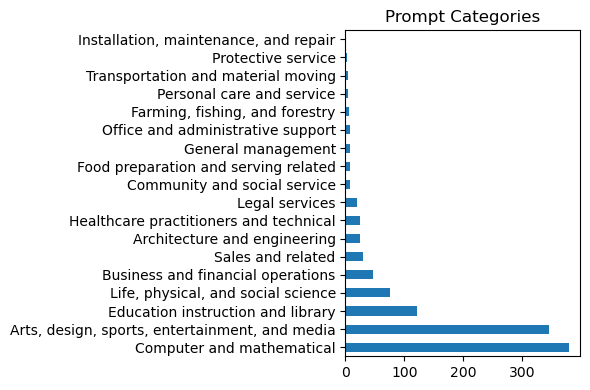

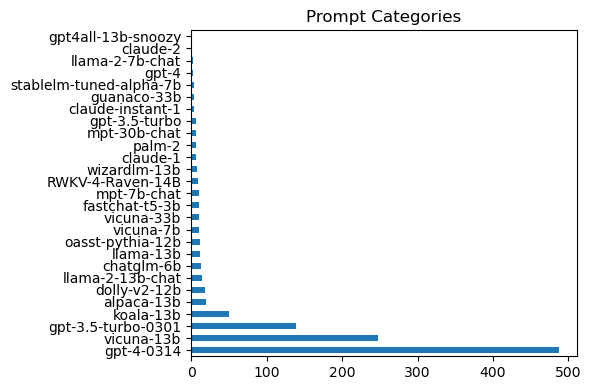

In [36]:
(final["category"]
 .value_counts()
 .plot.barh(figsize=(6,4), title="Prompt Categories"))

plt.tight_layout()
plt.show()

final["model"] = final["metadata"].apply(
    lambda m: m.get("model") if isinstance(m, dict) else None
)

(final["model"]
 .value_counts()
 .plot.barh(figsize=(6,4), title="Prompt Categories"))

plt.tight_layout()
plt.show()